In [3]:
import os
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')

In [2]:
import torch
# torch.manual_seed(0)
import pandas as pd
import wandb
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import TensorDataset,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import Resize

import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

# from neurora.rdm_corr import rdm_correlation_spearman

/mnt/ws/home/ssuresh/miniconda3/envs/thingsvision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define model

In [4]:
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=10):
        super().__init__()
        ""
        ### Convolutional section
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label

In [5]:
### custom loss computing triplet loss and labeling loss


class CustomLoss(nn.Module):
    def __init__(self, margin=10):
        super(CustomLoss, self).__init__()
        self.margin = margin
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, anchor, positive, negative, label, pred_label):
        cosine_sim = torch.nn.CosineSimilarity(1)
        # distance_positive = torch.tensor(1)-cosine_sim(anchor,positive)
   
        # distance_negative = torch.tensor(1)-cosine_sim(anchor,negative)

        # triplet_loss = torch.maximum(distance_positive - distance_negative + self.margin, torch.tensor(0))
        # triplet_loss = torch.sum(triplet_loss)
        triplet_loss = (nn.TripletMarginWithDistanceLoss( distance_function=lambda x, y: 1.0 - F.cosine_similarity(x, y)))
        triplet_loss = triplet_loss(anchor, positive, negative)
        label_loss = F.binary_cross_entropy_with_logits(pred_label.float(), label.float())
        total_loss = triplet_loss + label_loss
        return triplet_loss, label_loss, total_loss

In [6]:
t = TripletLabelModel()
cifar_model_path = '../../data/CIFAR10_NCE_i_1e-05_50.pth'
t.load_state_dict(torch.load(cifar_model_path))



/mnt/ws/home/ssuresh/miniconda3/envs/thingsvision/lib/python3.9/site-packages/torch/cuda/__init__.py:155: UserWarning: 
NVIDIA H100 PCIe with CUDA capability sm_90 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70 sm_75 sm_80 sm_86.
If you want to use the NVIDIA H100 PCIe GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


<All keys matched successfully>

### Training functions

In [35]:


class TrainModels(nn.Module):
    def __init__(self, latent_dims, num_classes, weights_path=None):
        super(TrainModels, self).__init__()
        self.triplet_lab_model = TripletLabelModel(latent_dims, 10) ### load cifar model
        if weights_path!=None:
            cifar_model_path = '../../data/CIFAR10_NCE_i_1e-05_50.pth'
            self.triplet_lab_model.load_state_dict(torch.load(cifar_model_path))
            self.triplet_lab_model.decoder_labels_lin[4] = nn.Linear(16, num_classes)
        self.custom_loss = CustomLoss()
        self.num_classes = num_classes
    
    def forward(self, anchor_im, positive_im, negative_im):
        anchor_latent, anchor_label = self.triplet_lab_model(anchor_im)
        positive_latent, _ = self.triplet_lab_model(positive_im)
        negative_latent, _ = self.triplet_lab_model(negative_im)

        return anchor_latent, positive_latent, negative_latent, anchor_label

    def test_epoch(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            test_triplet_loss = []
            test_label_loss = []
            test_total_loss = []
            total = 0
            correct = 0
            for anchor_ims, option_1_ims, option_2_ims, labels, correct_option in test_data:
                # Move tensor to the proper device
                anchor_ims = anchor_ims.to(device)
                option_1_ims = option_1_ims.to(device)
                option_2_ims = option_2_ims.to(device)
                labels = F.one_hot(labels, num_classes=self.num_classes)
                labels = labels.to(device)
                if correct_option==0:
                    anchor_latent, positive_latent, negative_latent, pred_label = self.forward(anchor_ims, option_1_ims,option_2_ims) 
                elif correct_option==1:
                    anchor_latent, positive_latent, negative_latent, pred_label = self.forward(anchor_ims, option_2_ims, option_1_ims)
                # Append the network output and the original image to the lists
                triplet_loss, label_loss, total_loss = self.custom_loss(anchor_latent,
                                                                positive_latent, 
                                                                negative_latent, 
                                                                labels,
                                                                pred_label)
                total += labels.size(0)
                correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(labels, dim = 1)).sum().item()
                test_triplet_loss.append(triplet_loss.item())
                test_label_loss.append(label_loss.item())
                test_total_loss.append(total_loss.item())
        test_triplet_loss = sum(test_triplet_loss)/len(test_triplet_loss)
        test_label_loss = sum(test_label_loss)/len(test_label_loss)
        test_total_loss = sum(test_total_loss)/len(test_total_loss)
        test_accuracy = correct/total
        return test_triplet_loss, test_label_loss, test_total_loss, test_accuracy

    def test_epoch_calculate_representation_separation(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            accuracies = []
            for anchor_ims, option_1_ims, option_2_ims, labels, correct_option in test_data:
                # Move tensor to the proper device
                anchor_ims = anchor_ims.to(device)
                # labels = F.one_hot(labels, num_classes=self.num_classes)
                # labels = labels.to(device)
                anchor_latent, _, _, _ = self.forward(anchor_ims, option_1_ims,option_2_ims) 
                # use sklearn to predict labels from anchor_latent
                # calculate accuracy
                # x's are anchor_latent and y's are labels
                # append accuracy to list
                # put anchor_latent and labels on cpu and convert to numpy

          
                anchor_latent = anchor_latent.cpu().numpy()
                ### standard scale the data in anchor_latent before fitting to the model
                anchor_latent = StandardScaler().fit_transform(anchor_latent)
                labels = labels.cpu().numpy()
                
                lm = linear_model.LogisticRegression()
                lm.fit(anchor_latent, labels)
                # convert labels to sklearn format
                accuracies.append(lm.score(anchor_latent, labels))
        accuracy = sum(accuracies)/len(accuracies)
        return accuracy

    def train_epoch(self, train_data, optimizer, train_mode):
        self.train()
        train_triplet_loss = []
        train_label_loss = []
        train_total_loss = []
        correct = 0
        total = 0
        for anchor_ims, option_1_ims, option_2_ims, labels, correct_option in train_data:
            
            anchor_ims = anchor_ims.to(device)
            option_1_ims = option_1_ims.to(device)
            option_2_ims = option_2_ims.to(device)
            labels = F.one_hot(labels, num_classes=self.num_classes)
            labels = labels.to(device)

            optimizer.zero_grad()
            if correct_option==0:
                anchor_latent, positive_latent, negative_latent, pred_label = self.forward(anchor_ims, option_1_ims,option_2_ims)
            elif correct_option==1:
                anchor_latent, positive_latent, negative_latent, pred_label = self.forward(anchor_ims, option_2_ims, option_1_ims)
           
           
            triplet_loss, label_loss, total_loss = self.custom_loss(anchor_latent,
                                                                positive_latent, 
                                                                negative_latent, 
                                                                labels,
                                                                pred_label)
            
            
            if train_mode==0:
                triplet_loss.backward()
            elif train_mode==1:
                label_loss.backward()
            elif train_mode==2:
                total_loss.backward()

            optimizer.step()
            train_triplet_loss.append(triplet_loss.item())
            train_label_loss.append(label_loss.item())
            train_total_loss.append(total_loss.item())
            total += labels.size(0)
            correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(labels, dim = 1)).sum().item()
        train_triplet_loss = sum(train_triplet_loss)/len(train_triplet_loss)
        train_label_loss = sum(train_label_loss)/len(train_label_loss)
        train_total_loss = sum(train_total_loss)/len(train_total_loss)
        train_accuracy = correct/total
        return train_triplet_loss, train_label_loss, train_total_loss, train_accuracy

    def training_loop(self, train_data, test_data,train_mode,
                      epochs, optimizer):
        train_losses = []
        val_losses = []
        train_triplet_losses = []
        val_triplet_losses = []
        train_label_losses = []
        val_label_losses = []
        train_accuracies = []
        val_accuracies = []
        latent_separation_accuracy = 0
        for epoch in tqdm(range(epochs)):
          train_triplet_loss, train_label_loss, train_total_loss, train_accuracy =self.train_epoch(train_data, optimizer, 
                                             train_mode)
          test_triplet_loss, test_label_loss, test_total_loss, test_accuracy = self.test_epoch(test_data)
          separation_accuracy = self.test_epoch_calculate_representation_separation(test_data)
          train_losses.append(train_total_loss)
          val_losses.append(test_total_loss)
          train_triplet_losses.append(train_triplet_loss)
          val_triplet_losses.append(test_triplet_loss)
          train_label_losses.append(train_label_loss)
          val_label_losses.append(test_label_loss)
          train_accuracies.append(train_accuracy)
          val_accuracies.append(test_accuracy)
          wandb.log({"train triplet loss": train_triplet_loss, 
            "train label loss":train_label_loss, 
            "validation triplet loss":test_triplet_loss, 
            "validation label loss":test_label_loss, 
            "total train loss":train_total_loss, 
            "total validation loss":test_total_loss, 
            "train label accuracy":train_accuracy, 
            "validation label accuracy":test_accuracy,
            'latent separation accuracy':separation_accuracy})
        return train_triplet_losses, train_label_losses, val_triplet_losses, val_label_losses ,train_losses, val_losses, train_accuracies, val_accuracies

    def create_training_dataset(self, df, label_mapping):
        def reshape_array(flat_array):
            return flat_array.reshape(64, 128, 3)
        anchor_ims = torch.tensor(np.stack(df['test_image'].apply(lambda x: reshape_array(np.array(x))).values).transpose(0,3,1,2)/255).float()
        option_1_ims = torch.tensor(np.stack(df['option_1'].apply(lambda x: reshape_array(np.array(x))).values).transpose(0,3,1,2)/255).float()
        option_2_ims = torch.tensor(np.stack(df['option_2'].apply(lambda x: reshape_array(np.array(x))).values).transpose(0,3,1,2)/255).float()
        df['trial_type'] = df['trial_type'].map(label_mapping)
        labels = torch.tensor(df['trial_type']).to(torch.int64)
        correct_options = torch.tensor(df['correct_option'])
        return TensorDataset(Resize(32)(anchor_ims), Resize(32)(option_1_ims), Resize(32)(option_2_ims), labels, correct_options)

In [5]:
# set_A_ims = np.load(os.path.join(data_dir, 'set_A.npy'))
# set_B_ims = np.load(os.path.join(data_dir, 'set_B.npy'))
# set_C_ims = np.load(os.path.join(data_dir, 'set_C.npy'))
# set_A_labs = np.load(os.path.join(data_dir, 'set_A_labs.npy'))
# set_B_labs = np.load(os.path.join(data_dir, 'set_B_labs.npy'))
# set_C_labs = np.load(os.path.join(data_dir, 'set_C_labs.npy'))
import os
import pandas as pd
set_A_data = pd.read_parquet(os.path.join(data_dir, 'same_diff_train_exact_match_df_a.parquet'))
set_B_data = pd.read_parquet(os.path.join(data_dir, 'same_diff_train_exact_match_df_b.parquet'))
set_C_data = pd.read_parquet(os.path.join(data_dir, 'same_diff_train_exact_match_df_c.parquet'))
test_data = pd.read_parquet(os.path.join(data_dir, 'same_diff_train_exact_match_df.parquet'))

In [6]:
set_A_data

,trial_index,test_image,option_1_image,option_2_image,correct_option,test_categories,option_1_categories,option_2_categories,trial_type
0,7060,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[2, 3]","[3, 0]","[1, 1]",different
1,6234,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[3, 3]","[2, 2]","[0, 1]",same
2,2094,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[0, 0]","[3, 3]","[2, 1]",same
3,4663,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[2, 2]","[1, 1]","[3, 0]",same
4,7513,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",1,"[2, 0]","[3, 3]","[1, 0]",different
...,...,...,...,...,...,...,...,...,...
2995,5943,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[3, 0]","[0, 2]","[1, 1]",different
2996,5925,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[1, 3]","[2, 0]","[3, 3]",different
2997,1487,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",0,"[0, 2]","[1, 3]","[2, 2]",different
2998,4497,"[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...","[0.6, 0.8862745098039215, 0.9764705882352941, ...",1,"[1, 1]","[2, 0]","[3, 3]",same


In [9]:
set_C_data['trial_type'].value_counts()

trial_type
same         1523
different    1477
Name: count, dtype: int64

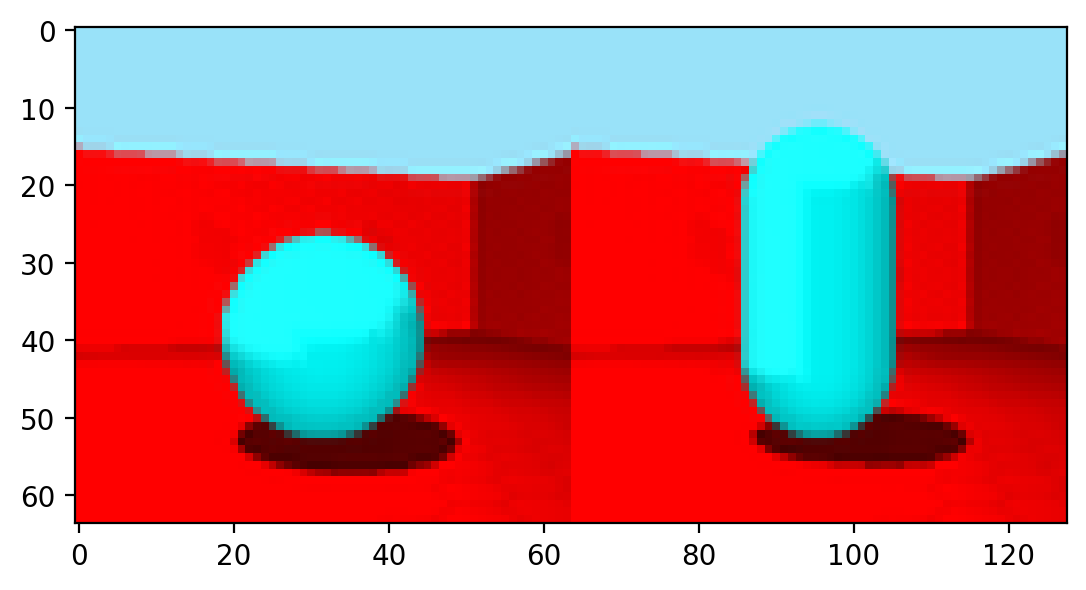

different


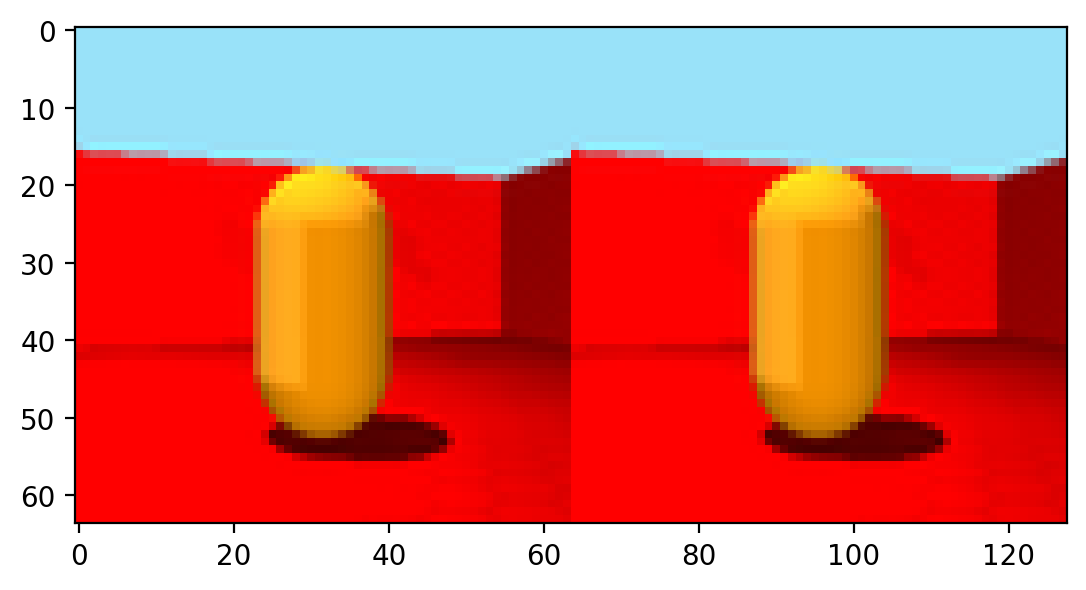

same


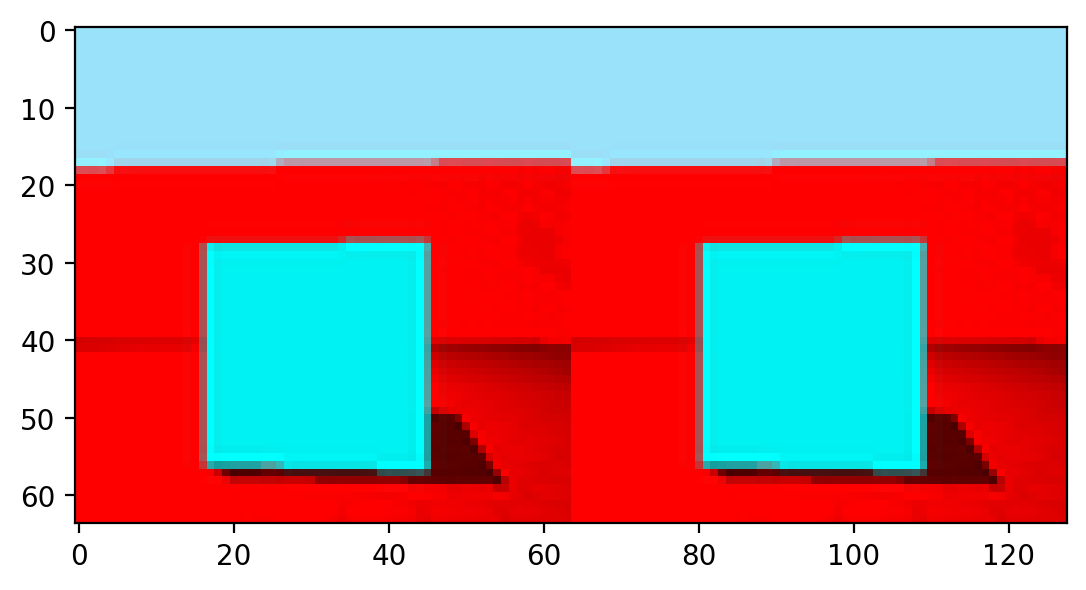

same


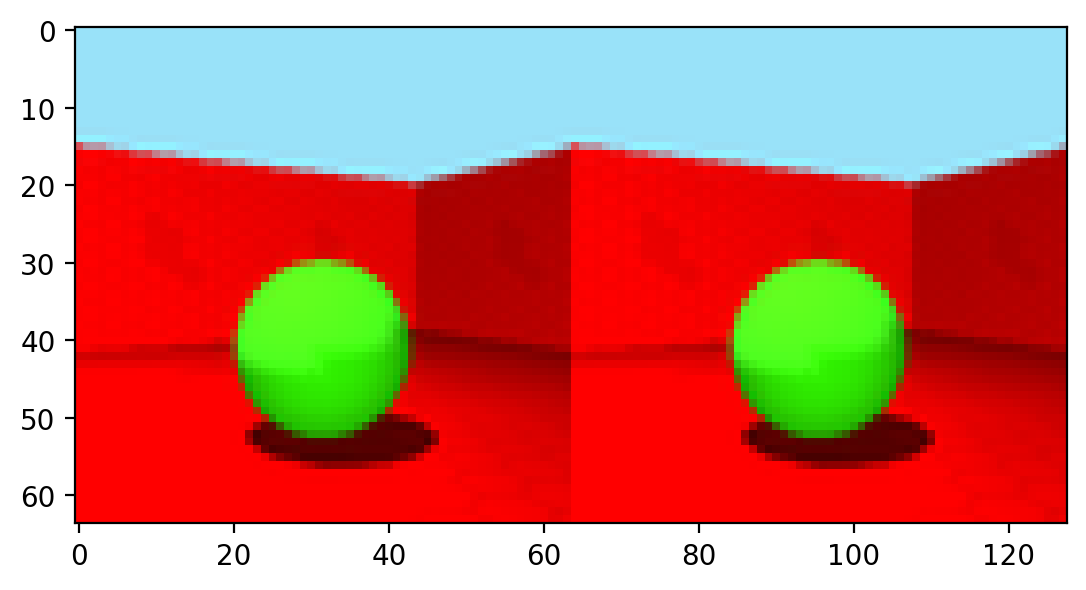

same


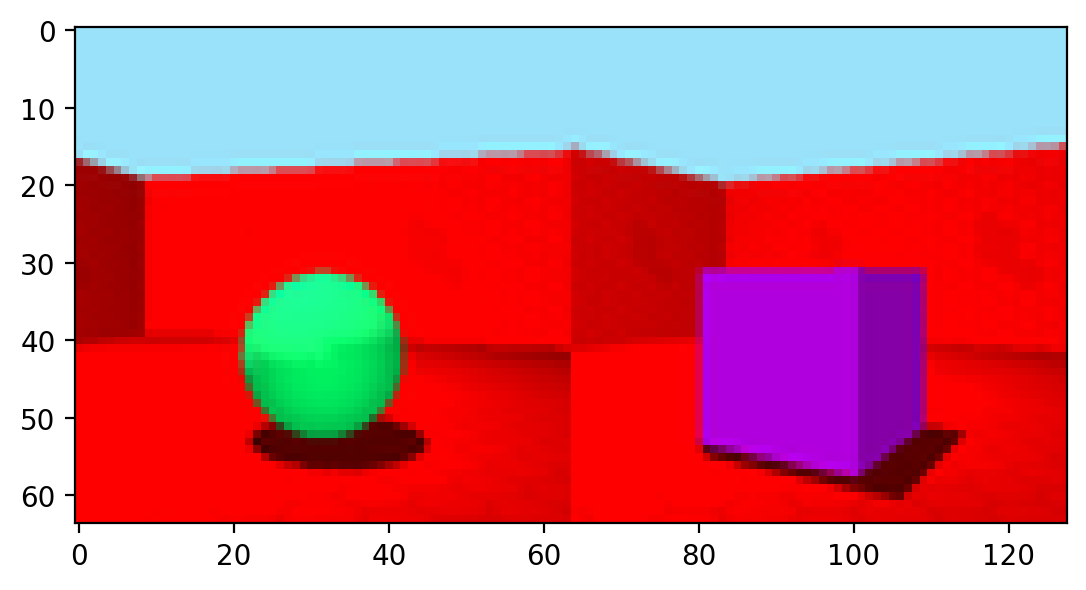

different


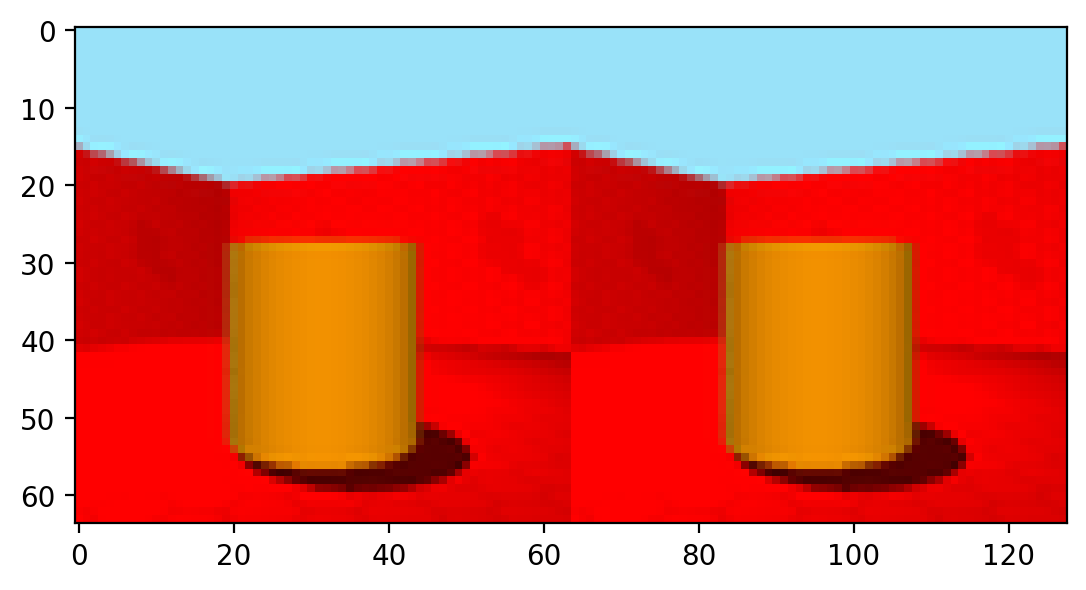

same


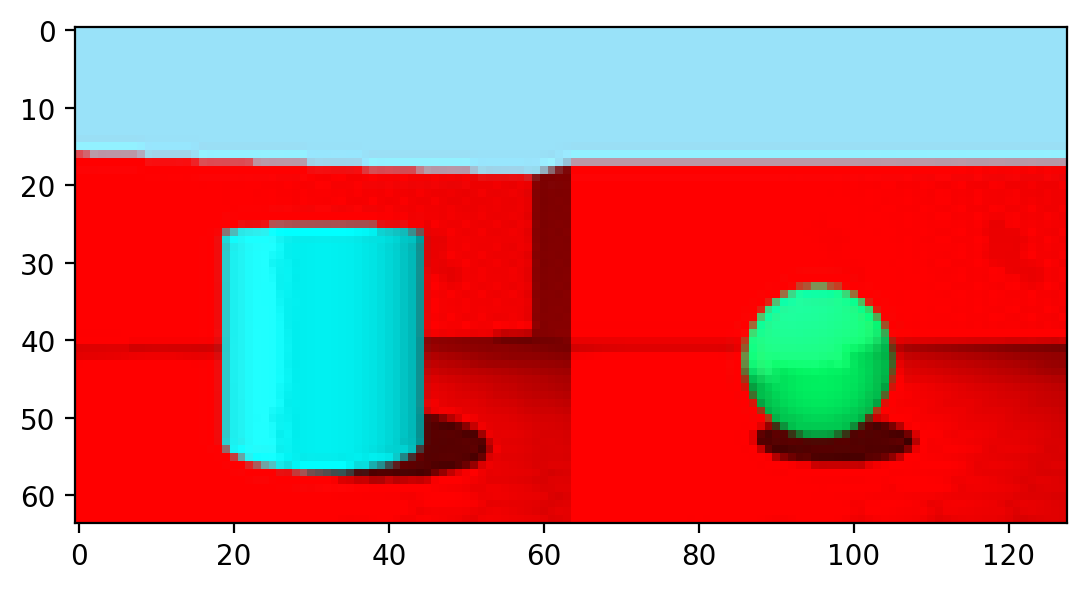

different


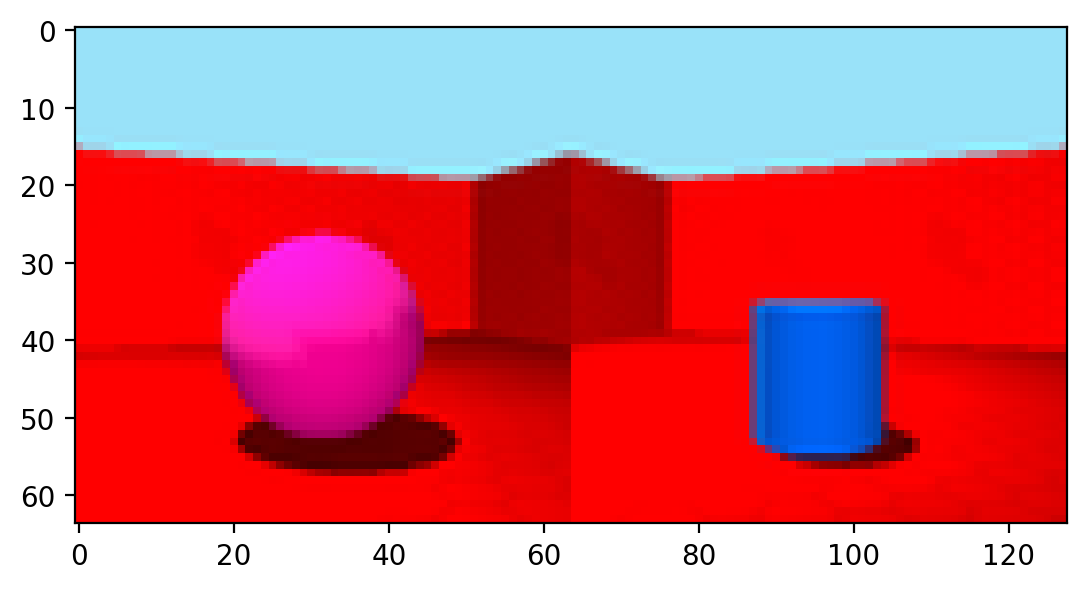

different


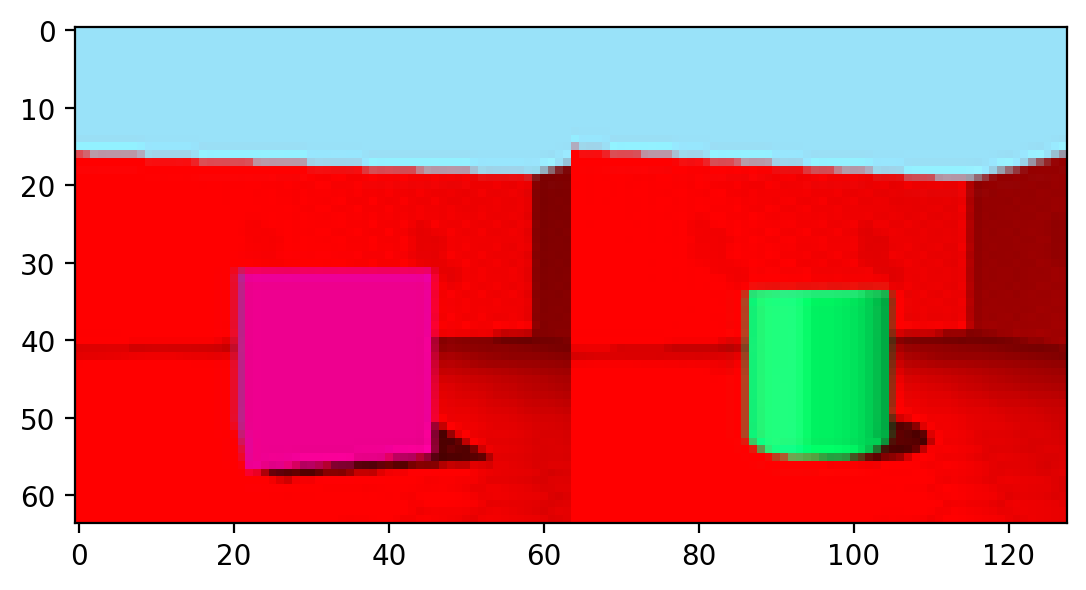

different


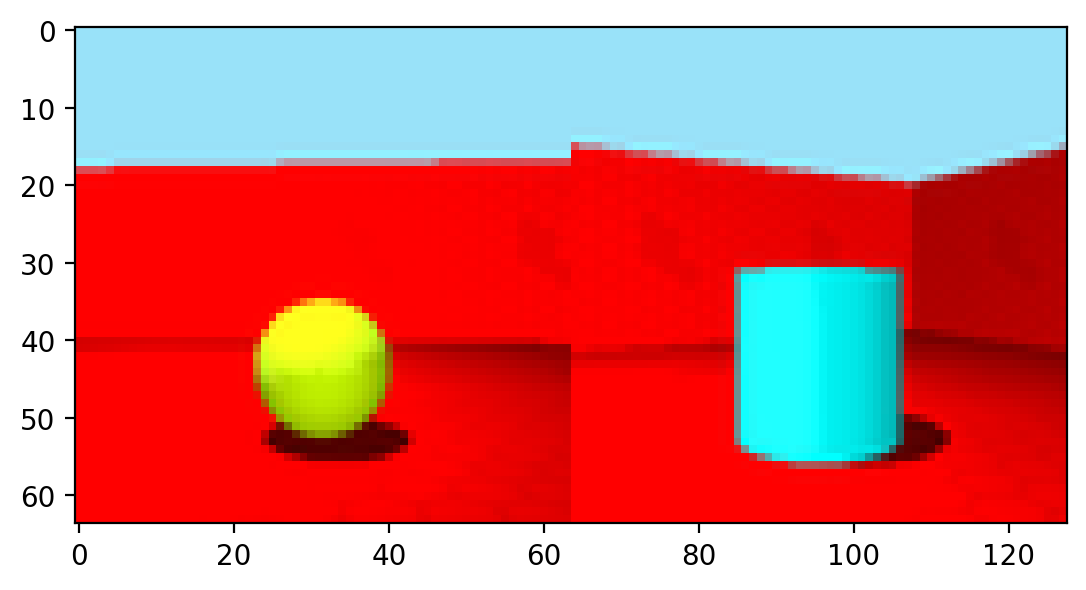

different


In [10]:
import matplotlib.pyplot as plt


for i in range(10):
    plt.imshow(set_A_data['test_image'].iloc[i].reshape(64, 128, 3))
    plt.show()
    # let the label be trial_type and put it on the image
    print(set_A_data['trial_type'].iloc[i])

In [38]:
# 40:60


In [39]:

# set_A_sub_ims =[]
# set_B_sub_ims =[]
# set_C_sub_ims =[]

# set_A_sub_labs =[]
# set_B_sub_labs =[]
# set_C_sub_labs =[]


# for i in range (4):
#     sub_main = set_A_ims[i*600:(i*600)+600]
#     labels_main = set_A_labs[i*600:(i*600)+600]
#     np.random.seed(711)
#     np.random.shuffle(sub_main)
#     np.random.seed(711)
#     np.random.shuffle(labels_main)

#     set_A_sub_ims.append(sub_main[:30])
#     set_B_sub_ims.append(sub_main[:15])
#     set_B_sub_ims.append(sub_main[30:45])
#     set_C_sub_ims.append(sub_main[35:65])

#     set_A_sub_labs.append(labels_main[:30])
#     set_B_sub_labs.append(labels_main[:15])
#     set_B_sub_labs.append(labels_main[30:45])
#     set_C_sub_labs.append(labels_main[35:65])


    




# ##flatten set_A_sub_ims into an array of shape 120,64,64,3
# set_A_sub_ims = np.concatenate(set_A_sub_ims)
# set_B_sub_ims = np.concatenate(set_B_sub_ims)
# set_C_sub_ims = np.concatenate(set_C_sub_ims)

# set_A_sub_labs = np.concatenate(set_A_sub_labs)
# set_B_sub_labs = np.concatenate(set_B_sub_labs)
# set_C_sub_labs = np.concatenate(set_C_sub_labs)


A-B: 50% \
A-C: 0% \
B-C: 33.33%

In [40]:

###initialize weights and bias tracking
def wandb_init(epochs, lr, train_mode, batch_size, model_number,data_set):
  wandb.login(key = '0743dcb3e6cabcef48bfd9b18017ba1cd0722fd7')
  wandb.init(project="ConceptualAlignment2025", entity="sid-academic-team",settings=wandb.Settings(start_method="thread"))
  wandb.config = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size, 
    # "label_ratio":label_ratio, 
    "model_number": model_number,
    "dataset": data_set,
    "train_mode":train_mode,
  }
  train_mode_dict = {0:'triplet', 1:'label', 2:'label_and_triplet'}
  wandb.run.name = f'{data_set}_{train_mode_dict[train_mode]}_{model_number}'
  wandb.run.save()
     

In [41]:

def main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims):
  if os.path.isdir(save_dir):
    pass
  else:
    os.mkdir(save_dir)


  for data_set in ['set_A','set_B','set_C']:
    for train_mode in tqdm(range(3)):
     # torch.manual_seed(0)
      for model in range(num_models):
        weights_path = f'../../data/cifar_models/m{model}.pth'
        train_obj = TrainModels(latent_dims, num_classes,weights_path).to(device) # GPU
        wandb_init(epochs, lr, train_mode, batch_size, model,data_set)

        if data_set=='set_A':
          train_data = train_obj.create_training_dataset(set_A_data, label_mapping={'same': 0, 'different': 1})
        elif data_set=='set_B':
          train_data = train_obj.create_training_dataset(set_B_data, label_mapping={'same': 0, 'different': 1})
        elif data_set=='set_C':
          train_data = train_obj.create_training_dataset(set_C_data, label_mapping={'same': 0, 'different': 1})
          
        val_data = train_obj.create_training_dataset(test_data, label_mapping={'same': 0, 'different': 1})
        # train_data = torch.utils.data.Subset(train_data, train_indices)
       

        train_data = torch.utils.data.DataLoader(train_data, 
                                                batch_size=batch_size,
                                              shuffle=True)
        val_data = torch.utils.data.DataLoader(val_data, 
                                                batch_size=batch_size,
                                              shuffle=True)
        
     

        
        optimizer = torch.optim.Adam(train_obj.parameters(), lr=lr, weight_decay=1e-05)
        train_triplet_losses, train_label_losses, \
          val_triplet_losses, val_label_losses, \
            train_losses, val_losses, train_accuracies, val_accuracies= train_obj.training_loop(train_data = train_data,
                                                            test_data = val_data,
                                                            epochs = epochs,
                                                            optimizer = optimizer, 
                                                            train_mode = train_mode)




        print('validation triplet loss:',val_triplet_losses,'validation total loss:',val_losses,'validation accuracy:',val_accuracies)
        train_mode_dict = {0:'triplet', 1:'label',2:'label_and_triplet' }
        torch.save(train_obj.triplet_lab_model.state_dict(), os.path.join(save_dir,f'{model}_{data_set}_{train_mode_dict[train_mode]}.pth'))
        
        



In [42]:
wandb.finish()

num_classes = 4 # Number of unique class labels in the dataset
latent_dims = 64
epochs = 1000
lr = 0.005
num_models = 10
batch_size = 256
save_dir = save_dir
main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims)
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 